# Dukun Crypto Portfolio Analysis
Python notebook untuk menerawang harga cryptocurrency sebelum memutuskan untuk BUY, HOLD atau LEAVE this shitcoin berdasarkan porto kita sebelumnya.

---

## Pendahuluan

Tujuan dari notebook ini adalah untuk mendapatkan sudut pandang yang lebih baik tentang suatu koin atau token dari porto kita. Namun, bisa juga digunakan untuk portofolio jenis lain, terutama yang memiliki ekuitas. Satu-satunya batasan adalah ada tidaknya data histocalnya, yang bisa 
ditemukan secara gratis dari broker dan berbagai situs web.

> **NOTE:** *Pastikan kamu sudah membuat envi di Python 3 dan install packages di requirements.txt sebelum lanjut!*

---

## Pembahasan

Import package

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Sekarang `load` datanya. 

Pertama, kita `upload` datanya sehingga kita tahu kapan mau beli atau jual itu koin. Karena itulah diciptakannya notebook ini. Tanpa dataset yang akurat, analisis dibawah ini akan tidak bermakna. Kedua, mari ambil semua datasetnya.

In [4]:
# Load Porto
trades = pd.read_csv('portogue.csv', index_col=0)
trades.index = pd.to_datetime(trades.index)

# Menentukan nama ticker + fiatnya
fiat = 'usd'
tickers = list(set(trades['Buy']))
tickers = [ticker.lower() for ticker in tickers if ticker.lower() != fiat]

# Menentukan nama columnnya
column_names = ['Date', 'Close Price', 'Market Cap', 'Volume']

# Load data dari coingecko.com
market_data = {}
for filename in os.listdir('data'):
    ticker = filename.split('-')[0].lower()
    
    # Skip ticker yang ga perlu
    if ticker not in tickers:
        continue
    
    file_data = pd.read_csv('data' + os.sep + filename)

    # Rename column
    curr_column_names = list(file_data)
    column_names_map = {curr_column_names[i]: column_names[i] for i in range(len(column_names))}
    file_data.rename(columns=column_names_map, inplace=True)
    
    # Set index ke date dan convert ke np.datetime64
    file_data.set_index(['Date'], inplace=True)
    file_data.index = pd.to_datetime(file_data.index)  
    
    market_data[ticker] = file_data

Dengan aktivitas trading kita, kita mengcopy portofolio kita seperti kejadian di masa lalu. Intinya kita akan melakukan backtest sederhana, dengan strategi yang kita samakan dengan `share trading` kita. Ingatlah bahwa ini tidak memperhitungkan biaya `fee` dan saat ini hanya berlaku untuk data harian.

In [5]:
# define trade date
start_date = min(trades.index.values)
end_date = max([max(data.index.values) for _, data in market_data.items()])
trade_dates = np.arange(start_date, end_date + np.timedelta64(1, 'D'), np.timedelta64(1, 'D'))

# Pastikan bahwa baris pertama adalah cash deposit
if not np.isnan(trades.iloc[0]['Sell']):
    raise ValueError('Baris pertama di porto kamu haruslah cash deposit!.')

# Inialisasi holding dari ticker, dan asset performance
holdings = {ticker: 0.0 for ticker in tickers}
holdings[fiat] = trades.iloc[0]['Units']
asset_performance = {trade_date: {ticker: 0.0 for ticker in tickers} for trade_date in trade_dates}

# Hilangkan initial cash dari porto
actual_trades = trades.iloc[1:]

# Update holdings berdasarkan trade
def update_holdings(trade, holdings):
    # hindari cells NAN karena depo dan wd FIAT
    if not pd.isnull(trade['Sell']):
        holdings[trade['Sell'].lower()] -= trade['Units'] * trade['Value Per Unit']
    if not pd.isnull(trade['Buy']):
        holdings[trade['Buy'].lower()] += trade['Units']
        
# Loop tiap hari, execute trading strategy, dan record performance
for trade_date in trade_dates:
    
    # Update holding berdasarkan trade hari ini
    if trade_date in actual_trades.index:
        todays_trades = actual_trades.loc[trade_date]
        
        if type(todays_trades) is pd.DataFrame:
            
            # Multiple trades dihari yang sama
            for i in range(len(todays_trades)):
                update_holdings(todays_trades.iloc[i], holdings)
        else:
            # Single trade
            update_holdings(todays_trades, holdings)
    
    # Mark to porto
    for ticker in tickers:
        if trade_date in market_data[ticker].index:
            asset_performance[trade_date][ticker] = \
                holdings[ticker] * market_data[ticker].loc[trade_date]['Close Price']
        else:
            
            # Missing data
            if trade_date > start_date:
                asset_performance[trade_date][ticker] = \
                    asset_performance[trade_date - np.timedelta64(1, 'D')][ticker]

Pada ini, kita memiliki semua data yang kita butuhkan untuk mulai menghitung transformasi dan statistik yang menarik, seberapa menarik sih? cekidot!

In [7]:
# Ambil porto dan benchmark performance (bukan adjust untuk cash flows)
benchmark_performance = market_data['btc']['Close Price']
benchmark_performance = benchmark_performance[benchmark_performance.index >= start_date]
portfolio_performance = pd.DataFrame(index=trade_dates, columns=['Value'])
for date, assets in asset_performance.items():
    portfolio_performance['Value'].loc[date] = sum([value for ticker, value in assets.items()])

# Arithmetic dan Geometric
a_returns = portfolio_performance.pct_change().dropna()
g_returns = np.log(a_returns + 1)
benchmark_a_returns = benchmark_performance.pct_change().dropna()
benchmark_g_returns = np.log(benchmark_a_returns + 1)


cash_flows = {}
for trade_date in trade_dates:
    if trade_date in actual_trades.index:
        todays_trades = actual_trades.loc[trade_date]
        
        if type(todays_trades) is pd.DataFrame:
            
            for i in range(len(todays_trades)):
                if not pd.isnull(todays_trades['Buy'].iloc[i]) and pd.isnull(todays_trades['Sell'].iloc[i]):
                    cash_flows[trade_date] = -todays_trades['Units'].iloc[i]
                elif pd.isnull(todays_trades['Buy'].iloc[i]) and not pd.isnull(todays_trades['Sell'].iloc[i]):
                    cash_flows[trade_date] = todays_trades['Units'].iloc[i]
        else:
            
            if not pd.isnull(todays_trades['Buy']) and pd.isnull(todays_trades['Sell']):
                cash_flows[trade_date] = -todays_trades['Units']
            elif pd.isnull(todays_trades['Buy']) and not pd.isnull(todays_trades['Sell']):
                cash_flows[trade_date] = todays_trades['Units']

a_returns.drop(cash_flows.keys(), inplace=True)
g_returns.drop(cash_flows.keys(), inplace=True)
neg_g_returns = g_returns[g_returns < 0].dropna()
benchmark_neg_g_returns = benchmark_g_returns[benchmark_g_returns < 0].dropna()
benchmark_g_returns.drop(cash_flows.keys(), inplace=True)
adjusted_end_value = portfolio_performance['Value'].loc[end_date] + np.sum(list(cash_flows.values()))


benchmark_total_return = (benchmark_performance[end_date] / benchmark_performance[start_date]) - 1
benchmark_annualized_return = 365 * benchmark_g_returns.mean()
benchmark_annualized_volatility = np.sqrt(365) * benchmark_g_returns.std()
benchmark_annualized_downside_risk = np.sqrt(365) * benchmark_neg_g_returns.std()
benchmark_sharpe_ratio = benchmark_annualized_return / benchmark_annualized_volatility
benchmark_sortino_ratio = benchmark_annualized_return / benchmark_annualized_downside_risk
benchmark_cagr = ((benchmark_performance[end_date] / benchmark_performance[start_date]) \
                  ** (1 / (len(trade_dates) / 365))) - 1


total_return = (adjusted_end_value / portfolio_performance['Value'].loc[start_date]) - 1
annualized_return = 365 * g_returns.mean()
annualized_volatility = np.sqrt(365) * g_returns.std()
annualized_downside_risk = np.sqrt(365) * neg_g_returns.std()
sharpe_ratio = annualized_return / annualized_volatility
sortino_ratio = annualized_return / annualized_downside_risk
cagr = ((adjusted_end_value / portfolio_performance['Value'].loc[start_date]) \
        ** (1 / (len(trade_dates) / 365))) - 1
covariance_matrix = pd.concat([g_returns['Value'], benchmark_g_returns], axis=1).dropna().cov()
beta = covariance_matrix.iloc[0].iloc[1] / covariance_matrix.iloc[1].iloc[1]
alpha = annualized_return - (beta * 365 * benchmark_g_returns.mean())


window = 91  # 3 months
# window = 183  # 6 months
benchmark_rolling_g_returns = benchmark_g_returns.rolling(window)
portfolio_rolling_g_returns = g_returns.rolling(window)
benchmark_rolling_volatility = np.sqrt(365 / window) * benchmark_rolling_g_returns.std().dropna()
portfolio_rolling_volatility = np.sqrt(365 / window) * portfolio_rolling_g_returns.std().dropna()


asset_g_returns = pd.DataFrame(index=trade_dates, columns=tickers)
for ticker in tickers:
    asset_g_returns[ticker] = np.log(market_data[ticker]['Close Price'].pct_change().dropna() + 1)
asset_correlations = asset_g_returns.corr()


dates = [date for date in trade_dates if date not in cash_flows.keys()]
performance = pd.DataFrame(index=dates, columns=['Benchmark (BTC)', 'Portfolio'])
start_value = 100000
performance['Benchmark (BTC)'].iloc[0] = start_value
performance['Portfolio'].iloc[0] = start_value
for i in range(len(dates) - 1):
    performance['Benchmark (BTC)'].iloc[i + 1] = (benchmark_a_returns.iloc[i] + 1) * \
        performance['Benchmark (BTC)'].iloc[i]
    performance['Portfolio'].iloc[i + 1] = (a_returns['Value'].iloc[i] + 1) * performance['Portfolio'].iloc[i]


## Hasil

Done, lanjut visualisasi!

---

STATISTICS
---------------------------------------------------------------
			Benchmark (BTC)		Portfolio
Total Return		489.6%			752.1%
Annualized Return	313.9%			375.5%
Annualized Volatility	106.7%			111.1%
CAGR			1932.9%			3699.2%
Sharpe Ratio		2.94			3.38
Sortino Ratio		4.56			4.48
Alpha			N/A			124.8%
Beta			N/A			79.9%
---------------------------------------------------------------


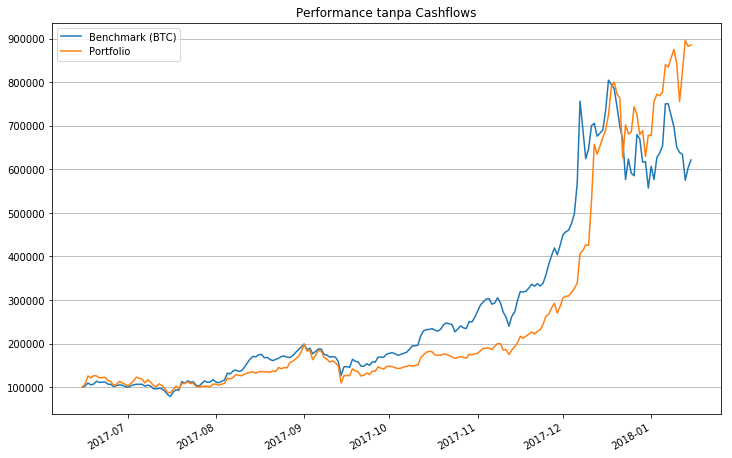

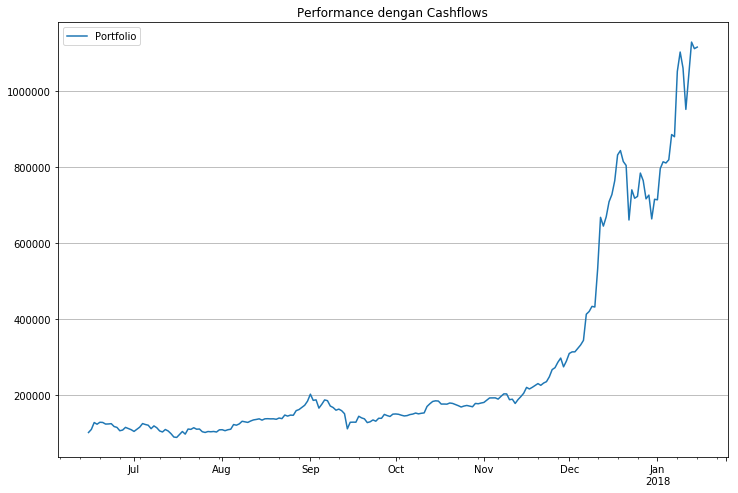

In [13]:
%matplotlib inline

print('STATISTICS')
print('---------------------------------------------------------------')
print('\t\t\tBenchmark (BTC)\t\tPortfolio')
print('Total Return\t\t%.1f%%\t\t\t%.1f%%' % (100 * benchmark_total_return, 100 * total_return))
print('Annualized Return\t%.1f%%\t\t\t%.1f%%' % (100 * benchmark_annualized_return, 100 * annualized_return))
print('Annualized Volatility\t%.1f%%\t\t\t%.1f%%' % (100 * benchmark_annualized_volatility, \
                                                   100 * annualized_volatility))
print('CAGR\t\t\t%.1f%%\t\t\t%.1f%%' % (100 * benchmark_cagr, 100 * cagr))
print('Sharpe Ratio\t\t%.2f\t\t\t%.2f' % (benchmark_sharpe_ratio, sharpe_ratio))
print('Sortino Ratio\t\t%.2f\t\t\t%.2f' % (benchmark_sortino_ratio, sortino_ratio))
print('Alpha\t\t\tN/A\t\t\t%.1f%%' % (100 * alpha))
print('Beta\t\t\tN/A\t\t\t%.1f%%' % (100 * beta))
print('---------------------------------------------------------------')

pd.options.mode.chained_assignment = None

performance.plot(figsize=(12, 8))
plt.title('Performance tanpa Cashflows')
plt.grid(axis='y')
plt.show()

portfolio_performance.plot(figsize=(12, 8))
plt.title('Performance dengan Cashflows')
plt.legend(['Portfolio'])
plt.grid(axis='y')
plt.show()


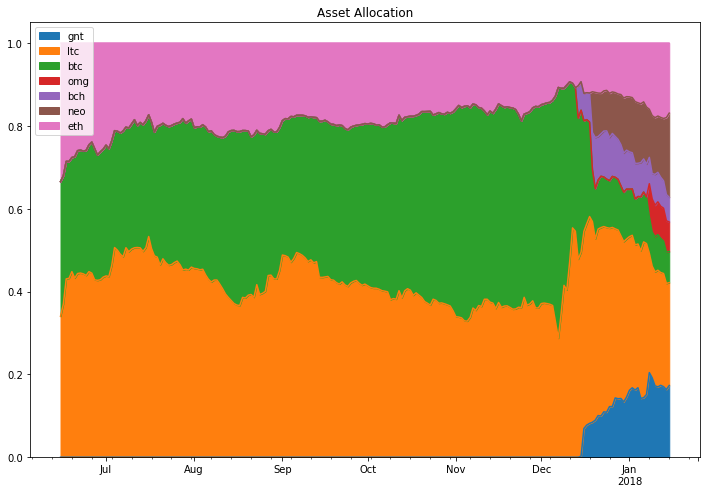

In [14]:
asset_allocation = pd.DataFrame(0, index=trade_dates, columns=tickers)
for date, asset_values in asset_performance.items():
    total_value = sum(asset_values.values())
    for ticker, value in asset_values.items():
        asset_allocation[ticker].loc[date] = value / total_value
asset_allocation.plot.area(figsize=(12, 8))
plt.title('Asset Allocation')
plt.legend(loc='upper left')
plt.show()

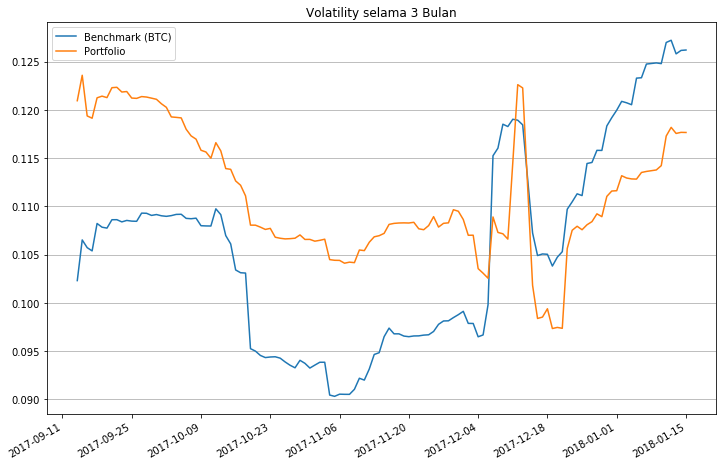

In [11]:

rolling_volatility = pd.DataFrame(index=portfolio_rolling_volatility.index, \
                                  columns=['Benchmark (BTC)', 'Portfolio'])
rolling_volatility['Benchmark (BTC)'] = benchmark_rolling_volatility
rolling_volatility['Portfolio'] = portfolio_rolling_volatility
rolling_volatility.plot(figsize=(12, 8))
plt.title('Volatility selama 3 Bulan')
plt.grid(axis='y')
plt.show()


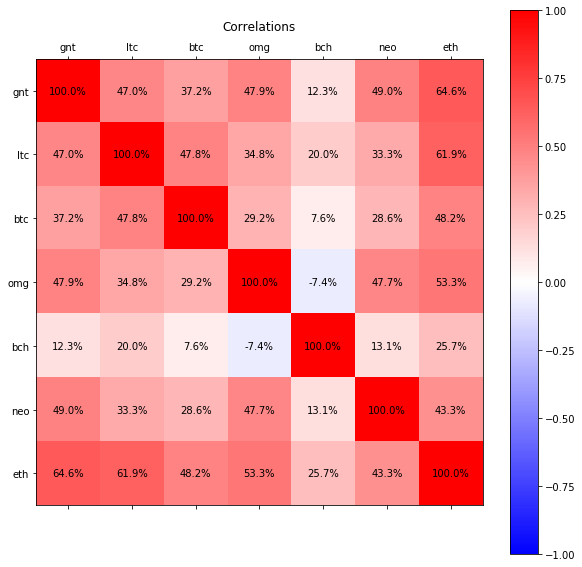

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xticklabels([''] + list(asset_correlations.keys()))
ax.set_yticklabels([''] + list(asset_correlations.keys()))
cax = ax.matshow(asset_correlations, cmap='bwr', vmin=-1.0, vmax=1.0)
for (i, j), z in np.ndenumerate(asset_correlations):
    ax.text(j, i, '{:.1f}%'.format(100 * z), ha='center', va='center')
plt.title('Correlations')
plt.colorbar(cax)
plt.show()